# Classification

In [2]:
!pip install plot_keras_history

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import time
import os

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics

import tensorflow as tf
from plot_keras_history import show_history, plot_history
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical

2024-02-23 00:05:57.335663: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


-Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée

-Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images

-Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation

-Une approche par DataSet, avec data augmentation intégrée au modèle : layer en début de modèle

# Import du dataset

In [4]:
path = "./Images/"
list_photos = [file for file in os.listdir(path)]
print(len(list_photos))

df = pd.read_csv("./flipkart_com-ecommerce_sample_1050.csv")
data = df[['image','product_category_tree']]

1050


# Création des labels

In [5]:
def recup_cat(liste_cat):
    """
    Renvoie la liste des catégories de liste_cat sans crochets ni apostrohes.
    Ainsi que la liste des différentes catégories.
    """
    liste = []
    l_cat = []
    for category in liste_cat:
        category = category.split(">>")[0]
        category = category.replace('"','').replace("'","").replace('[','')
        category = category[:-1]
        liste.append(category)
        if category not in(l_cat):
            l_cat.append(category)
    return liste, l_cat

In [6]:
categories, l_cat = recup_cat(data['product_category_tree'])

In [7]:
data['label_name'] = categories
data = data[['image','label_name']]
data

/var/folders/6p/1hr8w7kj7rxfl0_9t_x_f__w0000gn/T/ipykernel_95049/4074656248.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label_name'] = categories


,image,label_name
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing
...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care


In [8]:
le = preprocessing.LabelEncoder()
data["label"] = le.fit_transform(data["label_name"])
data

,image,label_name,label
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4
...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care,0
1046,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care,0
1047,5912e037d12774bb73a2048f35a00009.jpg,Baby Care,0
1048,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care,0


# Création du modèle de classification

Cette fonction create_model_fct() retourne un modèle CNN pré-entraîné basé sur l'architecture VGG16 avec un nouveau classifieur ajouté. Le modèle est chargé avec les poids entraînés sur l'ensemble de données ImageNet. Seuls les dernieres couches du modèle sont entraînables et les poids des couches de convolution sont figés. Le modèle est compilé avec une fonction de perte categorical_crossentropy et l'optimiseur rmsprop. Enfin, la fonction retourne le modèle.

In [9]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model

# Approche préparation initiale des images

Une approche de préparation d'image pour la classification d'images consiste à effectuer différentes opérations sur les images avant de les fournir à un algorithme de classification. Ces opérations visent à améliorer la qualité des données et à rendre les caractéristiques importantes plus facilement identifiables par l'algorithme de classification.

In [10]:
data_train, data_test = train_test_split(data, stratify=data['label'], test_size=0.2, random_state=0)
data_train.shape

(840, 3)

In [13]:
def image_prep_fct(data) :
    prepared_images = []
    for image_file in data['image'] :
        image_file = path+image_file
        img = load_img(image_file, target_size=(224, 224))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np = image_prep_fct(data_train)
print(images_np.shape)
images_np_test = image_prep_fct(data_test)
print(images_np_test.shape)

/Users/soraya/anaconda3/lib/python3.11/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(840, 224, 224, 3)
(210, 224, 224, 3)


In [14]:
X = images_np
y = to_categorical(data_train['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(630, 224, 224, 3)

In [16]:
# Création du modèle
model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

58889256/58889256 [==============================] - 30s 1us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                             

In [17]:
# Entraîner sur les données d'entraînement (X_train, y_train)
temps1 = time.time()

history1 = model1.fit(X_train, y_train, epochs=20, batch_size=64, 
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)

duration1 =time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 5.5861 - accuracy: 0.4460 
Epoch 1: val_loss improved from inf to 1.49156, saving model to ./model1_best_weights.h5
10/10 [==============================] - 228s 23s/step - loss: 5.5861 - accuracy: 0.4460 - val_loss: 1.4916 - val_accuracy: 0.7048
Epoch 2/20


/Users/soraya/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - ETA: 0s - loss: 1.8691 - accuracy: 0.6794 
Epoch 2: val_loss improved from 1.49156 to 1.18000, saving model to ./model1_best_weights.h5
10/10 [==============================] - 219s 22s/step - loss: 1.8691 - accuracy: 0.6794 - val_loss: 1.1800 - val_accuracy: 0.7762
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 1.0950 - accuracy: 0.7746 
Epoch 3: val_loss improved from 1.18000 to 0.97129, saving model to ./model1_best_weights.h5
10/10 [==============================] - 214s 22s/step - loss: 1.0950 - accuracy: 0.7746 - val_loss: 0.9713 - val_accuracy: 0.7905
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 0.8190 - accuracy: 0.7905 
Epoch 4: val_loss improved from 0.97129 to 0.94164, saving model to ./model1_best_weights.h5
10/10 [==============================] - 217s 22s/step - loss: 0.8190 - accuracy: 0.7905 - val_loss: 0.9416 - val_accuracy: 0.8143
Epoch 5/20
10/10 [==============================] - ET

In [18]:
loss1_train, accuracy1_train = model1.evaluate(X_train, y_train, verbose=True)
loss1_val, accuracy1_val = model1.evaluate(X_val, y_val, verbose=True)

7/7 [==============================] - 60s 9s/step - loss: 0.8554 - accuracy: 0.8571


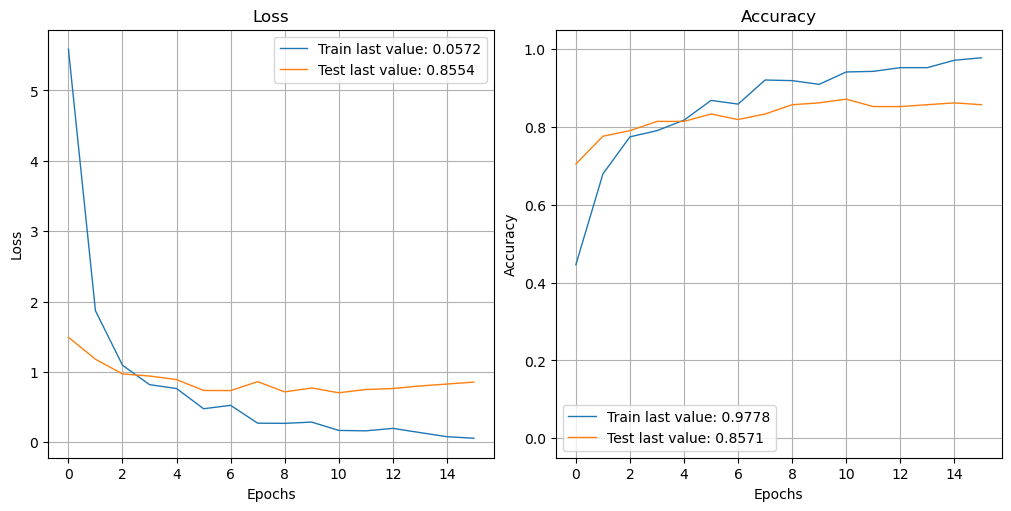

In [19]:
show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

Les scores sont très bons mais le modèle est en overfitting.

In [20]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 [==============================] - 62s 9s/step
[0 2 6 2 4 1 1 0 2 4 2 6 1 6 5 2 1 1 4 3 4 2 6 6 3 3 0 1 2 4 6 3 4 2 6 5 2
 5 6 3 0 2 6 5 2 0 1 6 4 6 5 3 3 3 5 3 5 4 4 0 4 0 6 6 2 5 0 0 1 3 5 3 5 1
 4 6 2 4 5 1 4 0 5 4 1 5 2 2 3 1 3 5 4 3 5 4 6 0 2 0 3 4 5 1 3 3 6 1 1 4 3
 0 3 2 5 2 1 6 1 4 5 5 3 0 0 3 2 6 3 6 5 1 2 6 6 1 1 5 3 4 3 3 5 1 0 4 5 0
 5 4 0 6 0 0 4 0 2 4 1 2 4 0 5 2 4 1 5 2 4 1 0 2 1 6 4 2 4 3 0 0 6 2 0 4 6
 5 0 2 3 1 6 0 6 1 5 0 5 0 2 3 1 6 1 2 1 3 6 3 6 5]

[0 2 6 2 4 1 1 0 2 4 2 6 5 6 5 2 1 6 4 3 4 2 6 6 3 3 0 3 5 4 6 3 4 2 6 5 2
 5 6 3 0 2 6 5 2 0 5 6 4 6 5 3 3 3 5 3 5 4 4 4 3 4 6 6 2 5 0 0 6 3 5 3 5 1
 4 6 2 4 5 1 4 0 5 4 1 2 2 2 0 1 3 5 4 0 5 4 6 0 2 0 3 4 5 5 3 3 6 3 3 4 3
 0 3 2 5 5 1 6 1 4 5 5 3 0 0 3 2 6 3 6 5 1 4 6 2 1 1 4 3 4 5 3 5 1 0 4 5 0
 5 3 0 6 0 0 4 0 2 4 1 2 4 5 5 2 4 1 2 2 4 1 3 2 2 6 4 2 0 3 0 5 6 2 1 0 6
 5 0 2 3 1 6 4 6 1 5 0 5 0 2 3 1 6 1 2 1 3 6 3 6 5]


In [21]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)
print(metrics.classification_report(y_val_num, y_val_pred))

[[23  1  0  1  3  2  0]
 [ 0 21  1  3  0  3  2]
 [ 0  0 27  0  1  2  0]
 [ 2  0  0 27  0  1  0]
 [ 2  0  0  2 26  0  0]
 [ 0  0  2  0  1 27  0]
 [ 0  0  1  0  0  0 29]]
              precision    recall  f1-score   support

           0       0.85      0.77      0.81        30
           1       0.95      0.70      0.81        30
           2       0.87      0.90      0.89        30
           3       0.82      0.90      0.86        30
           4       0.84      0.87      0.85        30
           5       0.77      0.90      0.83        30
           6       0.94      0.97      0.95        30

    accuracy                           0.86       210
   macro avg       0.86      0.86      0.86       210
weighted avg       0.86      0.86      0.86       210



In [22]:
class_names = ['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs',
             'Home Furnishing', 'Kitchen & Dining', 'Watches']

<Axes: >

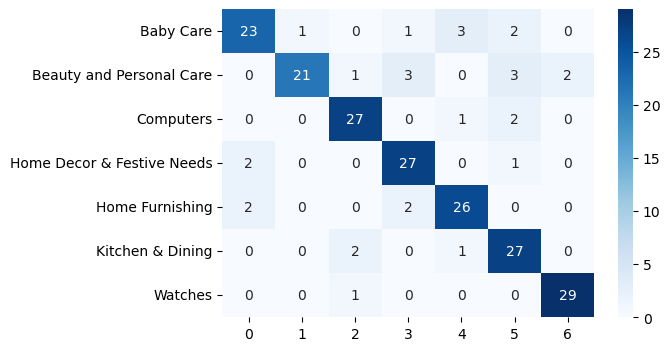

In [23]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in class_names],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

La matrice de confusion confirme les bons scores. On a une erreur au maximum de 3 sur 25 par catégorie.

**Prédictions sur data test**

In [24]:
test_loss1, test_acc1 = model1.evaluate(X_test, y_test, verbose = 1)
print('\nTest accuracy : ',test_acc1)

7/7 [==============================] - 63s 9s/step - loss: 1.2088 - accuracy: 0.8381

Test accuracy :  0.8380952477455139


In [25]:
predictions1 = model1.predict(X_test)

7/7 [==============================] - 65s 9s/step


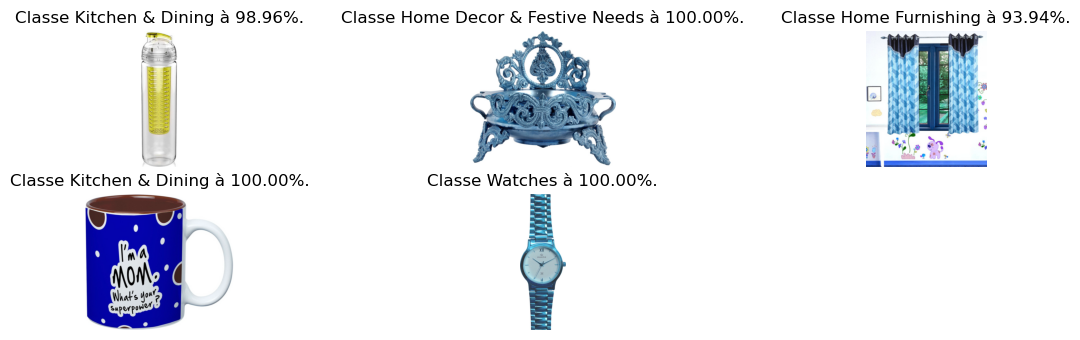

In [26]:
# Visualisation

plt.figure(figsize = (14,6))
for i in range(5):
    ax = plt.subplot(3, 3, i + 1)
    image = cv2.imread(path+data_test.iloc[10+i]['image'])
    plt.imshow(image)
    plt.title("Classe {} à {:.2f}%.".format(class_names[np.argmax(predictions1[10+i])], 100 * np.max(predictions1[10+i])))
    plt.axis("off")

Quelques exemples avec leurs prédictions. Les résultats sont corrects et la précision est très élevée.

In [27]:
labels_pred = [class_names[np.argmax(predictions1[i])] for i in range(len(predictions1))]
labels = data_test['label_name']
score1_ari = metrics.adjusted_rand_score(labels, labels_pred)
print("ARI : ", score1_ari)

ARI :  0.6620242929692114


# Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [28]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory = path,
                                x_col='image', y_col='label_name',
                                weight_col=None, target_size=(224, 224),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [29]:
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data_train, datagen_train, data_type='training')
val_flow = data_flow_fct(data_train, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

Found 630 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [30]:
# Création du modèle
model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [32]:
temps2 = time.time()

history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=20, callbacks=callbacks_list, verbose=1)
duration2=time.time()-temps2

print("temps de T-SNE : ", "%15.2f" % duration2, "secondes")

Epoch 1/20
 6/20 [========>.....................] - ETA: 2:27 - loss: 8.5765 - accuracy: 0.2083

/Users/soraya/anaconda3/lib/python3.11/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


20/20 [==============================] - ETA: 0s - loss: 4.8882 - accuracy: 0.4238 
Epoch 1: val_loss improved from inf to 1.42382, saving model to ./model2_best_weights.h5
20/20 [==============================] - 279s 14s/step - loss: 4.8882 - accuracy: 0.4238 - val_loss: 1.4238 - val_accuracy: 0.6952
Epoch 2/20


/Users/soraya/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - ETA: 0s - loss: 1.9329 - accuracy: 0.6381
Epoch 2: val_loss improved from 1.42382 to 1.21646, saving model to ./model2_best_weights.h5
20/20 [==============================] - 263s 13s/step - loss: 1.9329 - accuracy: 0.6381 - val_loss: 1.2165 - val_accuracy: 0.7143
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 1.1578 - accuracy: 0.7206
Epoch 3: val_loss improved from 1.21646 to 1.10210, saving model to ./model2_best_weights.h5
20/20 [==============================] - 232s 12s/step - loss: 1.1578 - accuracy: 0.7206 - val_loss: 1.1021 - val_accuracy: 0.7571
Epoch 4/20
20/20 [==============================] - ETA: 0s - loss: 0.8574 - accuracy: 0.7841
Epoch 4: val_loss improved from 1.10210 to 1.06251, saving model to ./model2_best_weights.h5
20/20 [==============================] - 230s 12s/step - loss: 0.8574 - accuracy: 0.7841 - val_loss: 1.0625 - val_accuracy: 0.7810
Epoch 5/20
20/20 [==============================] - ETA: 

In [35]:
loss2_train, accuracy2_train = model2.evaluate(train_flow, verbose=True)
loss2_val, accuracy2_val = model2.evaluate(val_flow, verbose=True)

7/7 [==============================] - 67s 9s/step - loss: 0.8883 - accuracy: 0.8000


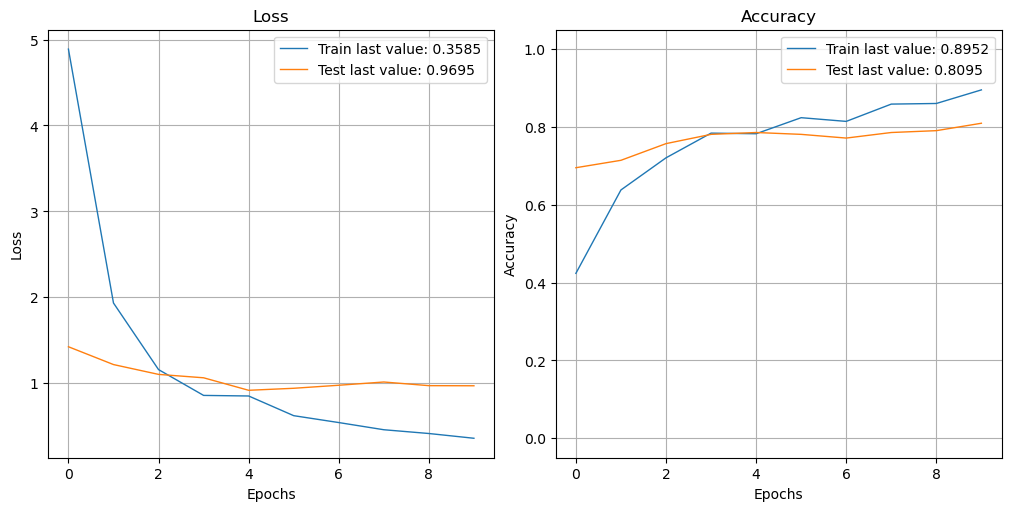

In [36]:
show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

Les scores sont très bons. Les résultats du train_set et du validation_set sont très proches. Le modèle arrive à généraliser.

In [38]:
predicted_labels = []
true_labels = []
for i in range(len(val_flow)):
    images, labels = val_flow[i]
    predicted_labels_batch = model2.predict(images)
    predicted_labels += list(np.argmax(predicted_labels_batch, axis=1))
    true_labels += list(np.argmax(labels, axis=1))

# Créer la matrice de confusion
confusion_mat = metrics.confusion_matrix(true_labels, predicted_labels)

# Afficher la matrice de confusion
print(confusion_mat)
print(metrics.classification_report(true_labels, predicted_labels))

1/1 [==============================] - 5s 5s/step
[[19  0  3  1  6  1  0]
 [ 1 26  1  2  0  3  0]
 [ 0  1 26  2  0  1  3]
 [ 2  1  3 24  4  1  0]
 [ 4  0  0  1 18  0  0]
 [ 1  0  1  0  0 26  0]
 [ 0  0  0  0  0  0 28]]
              precision    recall  f1-score   support

           0       0.70      0.63      0.67        30
           1       0.93      0.79      0.85        33
           2       0.76      0.79      0.78        33
           3       0.80      0.69      0.74        35
           4       0.64      0.78      0.71        23
           5       0.81      0.93      0.87        28
           6       0.90      1.00      0.95        28

    accuracy                           0.80       210
   macro avg       0.79      0.80      0.79       210
weighted avg       0.80      0.80      0.79       210



<Axes: >

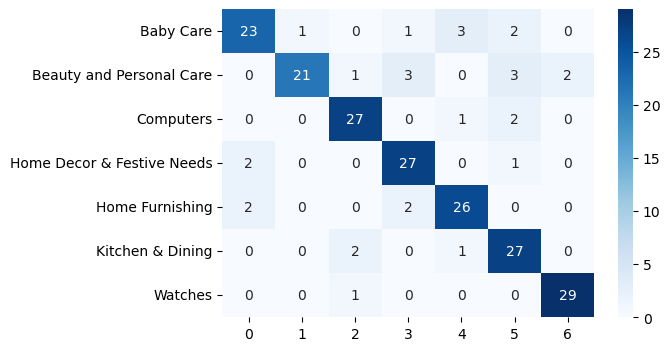

In [39]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in class_names],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

La matrice de confusion confirme les bons scores. On a une erreur au maximum de 3 sur 25 par catégorie.

# Prédictions sur le data test

In [41]:
predictions2 = []
true_labels = []
for i in range(len(test_flow)):
    images, labels = test_flow[i]
    predictions2_batch = model2.predict(images)
    predictions2 += list(np.argmax(predictions2_batch, axis=1))
    true_labels += list(np.argmax(labels, axis=1))

1/1 [==============================] - 6s 6s/step


In [42]:
score2_ari = metrics.adjusted_rand_score(true_labels, predictions2)
print("ARI : ", score2_ari)

ARI :  0.6319206866943567


In [43]:
score2_r2 = model2.evaluate(test_flow)[1]
print("r2 : ",score2_r2)

7/7 [==============================] - 65s 9s/step - loss: 1.4000 - accuracy: 0.8190
r2 :  0.8190476298332214


# Approche nouvelle par Dataset sans data augmentation

La méthode tf.keras.utils.image_dataset_from_directory réalise plusieurs prétraitements sur les images avant de les utiliser pour l'entraînement ou l'évaluation d'un modèle de deep learning.

Voici les principaux prétraitements effectués par cette méthode :

Redimensionnement : Par défaut, les images sont redimensionnées en entrée du modèle à la taille spécifiée dans l'argument image_size. Cela garantit que toutes les images ont la même taille, ce qui est une condition nécessaire pour que les images puissent être traitées en entrée d'un modèle de deep learning.

Normalisation : Les valeurs de pixel de chaque image sont divisées par 255 pour normaliser les intensités de pixels entre 0 et 1. Cela permet de stabiliser la distribution des valeurs de pixels entre les images et facilite l'optimisation du modèle.

Data Augmentation : Par défaut, la méthode tf.keras.utils.image_dataset_from_directory applique une augmentation de données légère aux images lors de l'entraînement du modèle. Cela consiste à appliquer des transformations aléatoires telles que des rotations, des translations, des zooms et des flips horizontaux sur les images. L'objectif de cette technique est de générer des images supplémentaires pour éviter le surapprentissage et améliorer la généralisation du modèle.

Conversion en tenseurs : Les images sont converties en tenseurs pour pouvoir être utilisées en entrée d'un modèle de deep learning. Par défaut, les tenseurs sont de type float32 et ont une forme (batch_size, image_height, image_width, num_channels), où batch_size correspond au nombre d'images dans le batch, image_height et image_width sont les dimensions des images redimensionnées, et num_channels est le nombre de canaux de couleur (3 pour les images RGB, 1 pour les images en niveaux de gris).

CF https://www.tensorflow.org/tutorials/load_data/images

# Création des répertoires de classes

In [44]:
# créer les dossiers du data_train

os.mkdir('./photos_train')

import shutil

for classe in l_cat:
    # Créer le dossier de la classe
    path_classe = './photos_train/class_'+classe+'/'
    os.mkdir(path_classe)
    
    # créer une liste des images de la classe
    l_images = data_train.loc[data_train["label_name"]==classe, 'image']
    
    # Définir le chemin complet du dossier de destination
    destination_path = path_classe
    
    for image in l_images :
        # Définir le chemin complet de l'image à copier
        source_path = './Images/'+image
    
        # Copier l'image vers le dossier de destination
        shutil.copy(source_path, destination_path)

In [45]:
# créer les dossiers du data_test

os.mkdir('./photos_test')

for classe in l_cat:
    # Créer le dossier de la classe
    path_classe = './photos_test/class_'+classe+'/'
    os.mkdir(path_classe)
    
    # créer une liste des images de la classe
    l_images = data_test.loc[data_test["label_name"]==classe, 'image']
    
    # Définir le chemin complet du dossier de destination
    destination_path = path_classe
    
    for image in l_images :
        # Définir le chemin complet de l'image à copier
        source_path = './Images/'+image
    
        # Copier l'image vers le dossier de destination
        shutil.copy(source_path, destination_path)

In [46]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None, data=data) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [47]:
chemin_train = './photos_train/'
chemin_test = './photos_test/'

dataset_train = dataset_fct(chemin_train, validation_split=0.25, data_type='training', data = data_train)
dataset_val = dataset_fct(chemin_train, validation_split=0.25, data_type='validation', data = data_train)
dataset_test = dataset_fct(chemin_test, validation_split=0, data_type=None, data = data_test)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [48]:
class_names = dataset_train.class_names
class_names

['class_Baby Care',
 'class_Beauty and Personal Care',
 'class_Computers',
 'class_Home Decor & Festive Needs',
 'class_Home Furnishing',
 'class_Kitchen & Dining',
 'class_Watches']

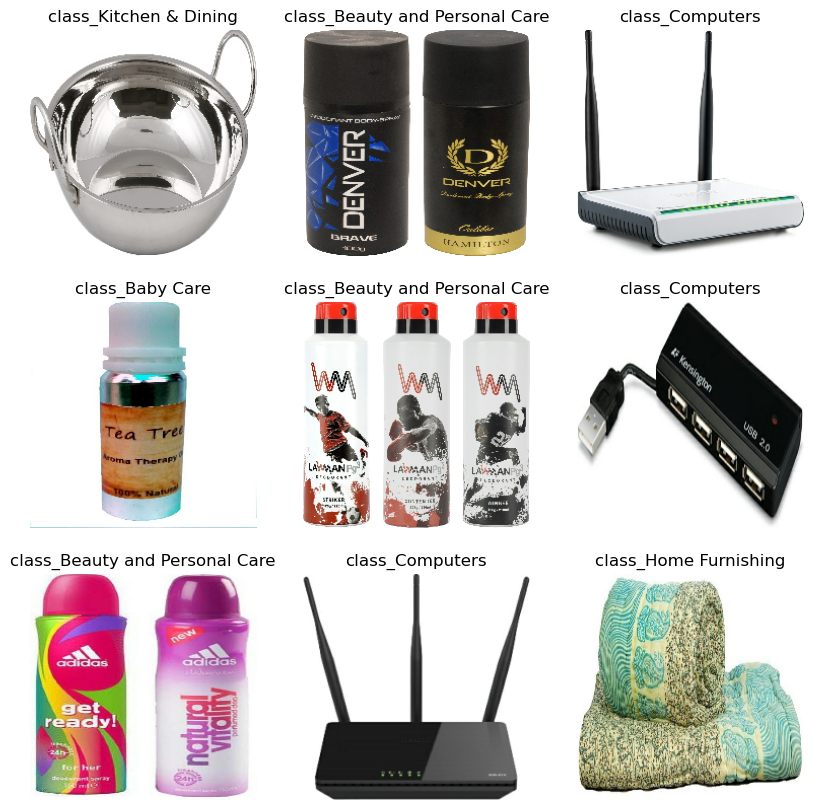

In [49]:
# Visualisation

plt.figure(figsize=(10, 10))
for images, labels in dataset_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [50]:
for image_batch, labels_batch in dataset_train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


L' image_batch est un tenseur de la forme (32, 224, 224, 3) . Il s'agit d'un lot de 32 images de forme 224x224x3 (la dernière dimension fait référence aux canaux de couleur RVB). Le label_batch est un tenseur de la forme (32,) , ce sont des labels correspondants aux 32 images.

In [51]:
# Création du modèle
model3 = create_model_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [54]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [56]:
temps3 = time.time()

history3 = model3.fit(dataset_train, validation_data=dataset_val,
                    batch_size=batch_size, epochs=20, callbacks=callbacks_list, verbose=1)

duration3=time.time()-temps3
print("temps de T-SNE : ", "%15.2f" % duration3, "secondes")

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 1.4052 - accuracy: 0.7302
Epoch 1: val_loss improved from 1.49615 to 0.99596, saving model to ./model3_best_weights.h5
20/20 [==============================] - 239s 12s/step - loss: 1.4052 - accuracy: 0.7302 - val_loss: 0.9960 - val_accuracy: 0.8333
Epoch 2/20
20/20 [==============================] - ETA: 0s - loss: 0.8163 - accuracy: 0.8159
Epoch 2: val_loss improved from 0.99596 to 0.79391, saving model to ./model3_best_weights.h5
20/20 [==============================] - 241s 12s/step - loss: 0.8163 - accuracy: 0.8159 - val_loss: 0.7939 - val_accuracy: 0.8190
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 0.6689 - accuracy: 0.8508
Epoch 3: val_loss improved from 0.79391 to 0.77800, saving model to ./model3_best_weights.h5
20/20 [==============================] - 245s 12s/step - loss: 0.6689 - accuracy: 0.8508 - val_loss: 0.7780 - val_accuracy: 0.8286
Epoch 4/20
20/20 [============================

In [57]:
loss3_train, accuracy3_train = model3.evaluate(dataset_train, verbose=True)
loss3_val, accuracy3_val = model3.evaluate(dataset_val, verbose=True)

7/7 [==============================] - 60s 8s/step - loss: 0.8507 - accuracy: 0.8143


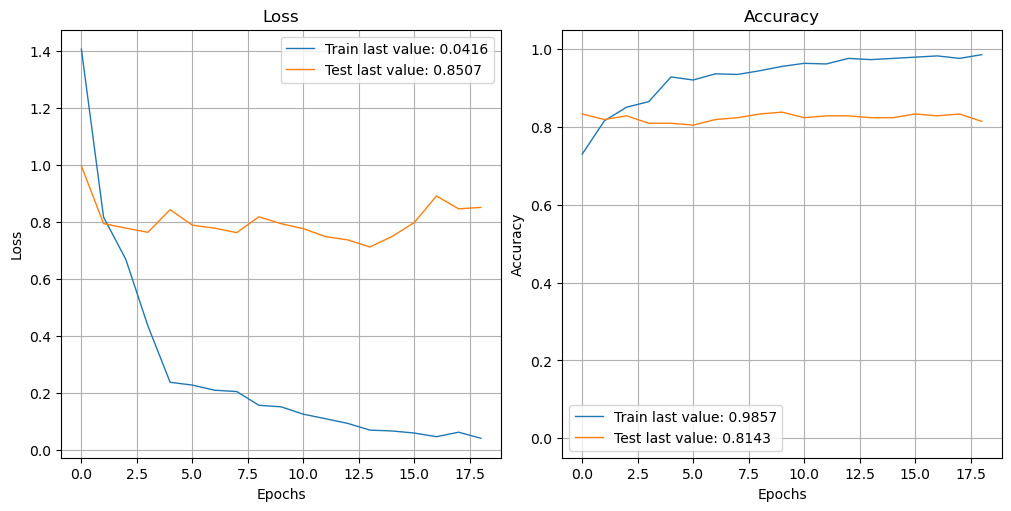

In [58]:
show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

In [59]:
predicted_labels = []
true_labels = []
for images, labels in dataset_val:
    predicted_labels_batch = model3.predict(images)
    predicted_labels += list(np.argmax(predicted_labels_batch, axis=1))
    true_labels += list(labels.numpy())
print(true_labels)
print()
print(predicted_labels)

1/1 [==============================] - 5s 5s/step
[2, 2, 6, 0, 1, 1, 2, 6, 4, 1, 4, 2, 5, 5, 6, 0, 2, 5, 4, 1, 3, 5, 1, 0, 5, 4, 0, 4, 5, 5, 0, 5, 3, 5, 5, 1, 4, 4, 4, 3, 3, 4, 1, 6, 5, 4, 5, 5, 6, 4, 3, 1, 5, 2, 5, 4, 4, 1, 4, 6, 1, 3, 0, 2, 0, 3, 0, 6, 6, 3, 5, 5, 2, 3, 0, 2, 3, 5, 2, 4, 6, 2, 4, 6, 6, 5, 5, 3, 4, 0, 4, 0, 6, 0, 4, 3, 4, 5, 5, 1, 5, 3, 2, 6, 6, 4, 6, 4, 5, 1, 2, 1, 3, 3, 3, 0, 4, 0, 0, 4, 3, 6, 0, 0, 2, 3, 6, 0, 4, 1, 3, 3, 0, 3, 0, 3, 2, 3, 2, 5, 2, 3, 1, 5, 1, 5, 1, 1, 6, 1, 5, 4, 6, 1, 1, 5, 6, 2, 2, 5, 2, 5, 5, 1, 3, 6, 3, 2, 5, 4, 3, 2, 3, 1, 6, 2, 6, 4, 3, 6, 5, 4, 6, 0, 6, 0, 3, 2, 5, 6, 0, 0, 0, 1, 1, 0, 3, 3, 3, 4, 2, 1, 5, 2, 6, 0, 3, 5, 0, 6]

[2, 2, 6, 4, 3, 1, 2, 6, 4, 1, 4, 2, 5, 0, 3, 0, 2, 5, 0, 1, 0, 5, 1, 0, 1, 4, 0, 4, 5, 5, 0, 5, 4, 5, 5, 1, 0, 4, 4, 3, 1, 4, 1, 6, 2, 4, 5, 5, 6, 4, 6, 4, 5, 2, 5, 4, 4, 1, 2, 6, 2, 5, 0, 2, 4, 3, 0, 6, 6, 3, 2, 5, 2, 3, 0, 2, 3, 5, 2, 4, 6, 2, 4, 3, 6, 2, 2, 3, 1, 0, 4, 0, 6, 4, 3, 3, 4, 5, 5, 3, 5, 3, 2, 6, 6, 4,

In [60]:
conf_mat = metrics.confusion_matrix(true_labels, predicted_labels)
print(conf_mat)
print(metrics.classification_report(true_labels, predicted_labels))

[[23  0  0  1  4  0  0]
 [ 2 20  1  2  1  0  0]
 [ 0  1 24  0  1  0  0]
 [ 2  2  0 24  1  3  2]
 [ 3  1  1  1 24  0  0]
 [ 1  1  5  0  0 30  0]
 [ 0  0  0  3  0  0 26]]
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        28
           1       0.80      0.77      0.78        26
           2       0.77      0.92      0.84        26
           3       0.77      0.71      0.74        34
           4       0.77      0.80      0.79        30
           5       0.91      0.81      0.86        37
           6       0.93      0.90      0.91        29

    accuracy                           0.81       210
   macro avg       0.81      0.82      0.81       210
weighted avg       0.82      0.81      0.81       210



<Axes: >

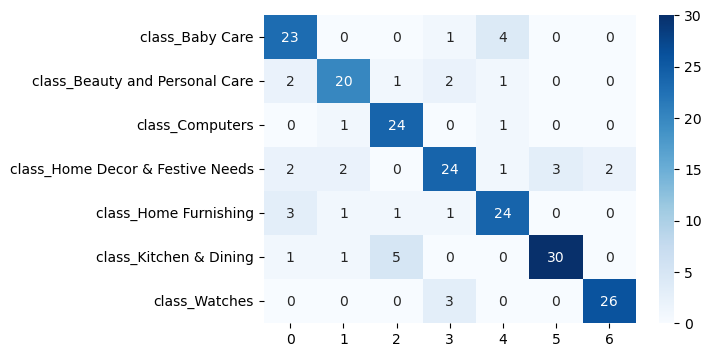

In [61]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in class_names],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

La matrice de confusion confirme les bons scores. La classe Kitchen et dining est trop souvent prédite.

**Prédictions sur le data test**

In [62]:
predictions3 = []
labels_test = []
for images, labels in dataset_test:
    predicted_labels_batch = model3.predict(images)
    predictions3 += list(np.argmax(predicted_labels_batch, axis=1))
    labels_test += list(labels.numpy())
print(labels_test)
print()
print(predictions3)

1/1 [==============================] - 6s 6s/step
[1, 5, 2, 1, 0, 1, 5, 5, 6, 1, 6, 3, 4, 0, 0, 4, 0, 2, 4, 4, 0, 6, 4, 2, 0, 1, 3, 4, 0, 5, 4, 2, 6, 1, 0, 4, 3, 0, 0, 2, 4, 5, 3, 0, 3, 6, 3, 5, 1, 3, 1, 4, 5, 0, 6, 1, 3, 0, 0, 0, 5, 4, 4, 4, 4, 2, 6, 4, 2, 0, 0, 2, 1, 6, 0, 3, 1, 6, 5, 6, 5, 2, 3, 0, 0, 6, 1, 2, 2, 6, 1, 3, 3, 5, 6, 4, 6, 4, 6, 4, 4, 1, 5, 2, 2, 1, 1, 1, 5, 3, 1, 2, 3, 6, 0, 5, 3, 1, 0, 6, 3, 6, 3, 5, 3, 5, 3, 6, 4, 5, 1, 1, 2, 3, 1, 4, 5, 0, 5, 3, 0, 4, 6, 1, 4, 3, 2, 1, 5, 3, 5, 5, 2, 4, 4, 4, 2, 2, 5, 1, 6, 6, 2, 6, 6, 1, 0, 3, 5, 5, 5, 3, 2, 6, 2, 0, 2, 6, 5, 1, 5, 1, 6, 1, 2, 2, 0, 4, 3, 2, 3, 0, 2, 1, 3, 0, 4, 3, 4, 4, 5, 0, 3, 2, 5, 6, 6, 2, 2, 6]

[2, 5, 2, 4, 0, 0, 5, 0, 6, 1, 6, 3, 2, 0, 0, 4, 0, 2, 4, 0, 4, 6, 4, 1, 0, 1, 3, 4, 0, 5, 4, 2, 6, 1, 0, 4, 3, 0, 4, 2, 4, 5, 3, 0, 3, 6, 3, 5, 1, 2, 5, 4, 5, 0, 6, 1, 3, 0, 0, 0, 1, 4, 4, 4, 4, 2, 6, 4, 3, 0, 0, 2, 1, 6, 0, 3, 2, 6, 5, 6, 5, 2, 3, 3, 3, 6, 1, 2, 2, 6, 1, 3, 3, 5, 6, 4, 6, 4, 6, 4, 4, 1, 5, 2, 2, 1,

In [63]:
score3_r2 = model3.evaluate(dataset_test)[1]
print("r2 : ",score3_r2)

7/7 [==============================] - 66s 9s/step - loss: 1.1080 - accuracy: 0.8238
r2 :  0.8238095045089722


In [64]:
score3_ari = metrics.adjusted_rand_score(labels_test, predictions3)
print("ARI : ", score3_ari)

ARI :  0.6371230610473211


# Approche nouvelle par Dataset avec data augmentation intégrée

L'approche dataset avec data augmentation intégrée est une méthode pour préparer les données d'entraînement d'un modèle de réseau de neurones convolutionnel, qui combine les avantages de l'approche dataset et de l'augmentation de données.

Dans cette approche, les données sont stockées dans un fichier ou une base de données, puis prétraitées comme dans l'approche dataset traditionnelle. Cependant, au lieu de simplement diviser les données en ensembles de formation, de validation et de test, les données d'entraînement sont augmentées en temps réel à l'aide de techniques d'augmentation de données telles que la rotation, le zoom, le décalage et la symétrie horizontale. Ces techniques sont appliquées aléatoirement à chaque image pendant l'entraînement, ce qui crée des variations des images originales, augmentant ainsi la quantité de données d'entraînement disponibles.

L'approche dataset avec data augmentation intégrée permet d'obtenir des performances similaires à celles de l'approche dataset traditionnelle avec l'augmentation de données appliquée séparément, mais avec moins de temps et d'efforts pour préparer les données. De plus, cette approche peut être plus efficace pour des ensembles de données plus petits où l'augmentation de données séparée peut ne pas être suffisamment diversifiée pour capturer la variabilité des données réelles.

In [65]:
batch_size = 32

In [66]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [67]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [68]:
# Création du modèle
model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

In [69]:
temps4 = time.time()

history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=35, callbacks=callbacks_list, verbose=1)

duration4=time.time()-temps4
print("temps de T-SNE : ", "%15.2f" % duration4, "secondes")

Epoch 1/35
20/20 [==============================] - ETA: 0s - loss: 1.8855 - accuracy: 0.2381 
Epoch 1: val_loss improved from inf to 1.44501, saving model to ./model4_best_weights.h5


/Users/soraya/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 282s 14s/step - loss: 1.8855 - accuracy: 0.2381 - val_loss: 1.4450 - val_accuracy: 0.7000
Epoch 2/35
20/20 [==============================] - ETA: 0s - loss: 1.4223 - accuracy: 0.5286
Epoch 2: val_loss improved from 1.44501 to 1.12773, saving model to ./model4_best_weights.h5
20/20 [==============================] - 240s 12s/step - loss: 1.4223 - accuracy: 0.5286 - val_loss: 1.1277 - val_accuracy: 0.7238
Epoch 3/35
20/20 [==============================] - ETA: 0s - loss: 1.1905 - accuracy: 0.6381
Epoch 3: val_loss improved from 1.12773 to 0.95517, saving model to ./model4_best_weights.h5
20/20 [==============================] - 235s 12s/step - loss: 1.1905 - accuracy: 0.6381 - val_loss: 0.9552 - val_accuracy: 0.7429
Epoch 4/35
20/20 [==============================] - ETA: 0s - loss: 1.0509 - accuracy: 0.6746
Epoch 4: val_loss improved from 0.95517 to 0.84505, saving model to ./model4_best_weights.h5
20/20 [==============================] - 245s 

2024-02-15 14:02:34.365605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:480: Filling up shuffle buffer (this may take a while): 146 of 256
2024-02-15 14:02:38.958823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.



Epoch 10: val_loss improved from 0.64806 to 0.62889, saving model to ./model4_best_weights.h5
20/20 [==============================] - 483s 25s/step - loss: 0.7464 - accuracy: 0.7492 - val_loss: 0.6289 - val_accuracy: 0.8095
Epoch 11/35
20/20 [==============================] - ETA: 0s - loss: 0.7326 - accuracy: 0.7587 
Epoch 11: val_loss did not improve from 0.62889
20/20 [==============================] - 494s 24s/step - loss: 0.7326 - accuracy: 0.7587 - val_loss: 0.6421 - val_accuracy: 0.7905
Epoch 12/35


2024-02-15 14:14:08.086697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:473: Filling up shuffle buffer (this may take a while): 229 of 256
2024-02-15 14:14:08.808842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


20/20 [==============================] - ETA: 0s - loss: 0.7125 - accuracy: 0.7762 
Epoch 12: val_loss improved from 0.62889 to 0.62341, saving model to ./model4_best_weights.h5
20/20 [==============================] - 425s 21s/step - loss: 0.7125 - accuracy: 0.7762 - val_loss: 0.6234 - val_accuracy: 0.8095
Epoch 13/35
20/20 [==============================] - ETA: 0s - loss: 0.7009 - accuracy: 0.7762  
Epoch 13: val_loss improved from 0.62341 to 0.60298, saving model to ./model4_best_weights.h5
20/20 [==============================] - 4427s 232s/step - loss: 0.7009 - accuracy: 0.7762 - val_loss: 0.6030 - val_accuracy: 0.8286
Epoch 14/35
20/20 [==============================] - ETA: 0s - loss: 0.6452 - accuracy: 0.8079
Epoch 14: val_loss did not improve from 0.60298
20/20 [==============================] - 243s 12s/step - loss: 0.6452 - accuracy: 0.8079 - val_loss: 0.6189 - val_accuracy: 0.8048
Epoch 15/35
20/20 [==============================] - ETA: 0s - loss: 0.6401 - accuracy: 0.798

In [70]:
loss4_train, accuracy4_train = model4.evaluate(dataset_train, verbose=True)
loss4_val, accuracy4_val = model4.evaluate(dataset_val, verbose=True)

7/7 [==============================] - 57s 8s/step - loss: 0.5580 - accuracy: 0.8333


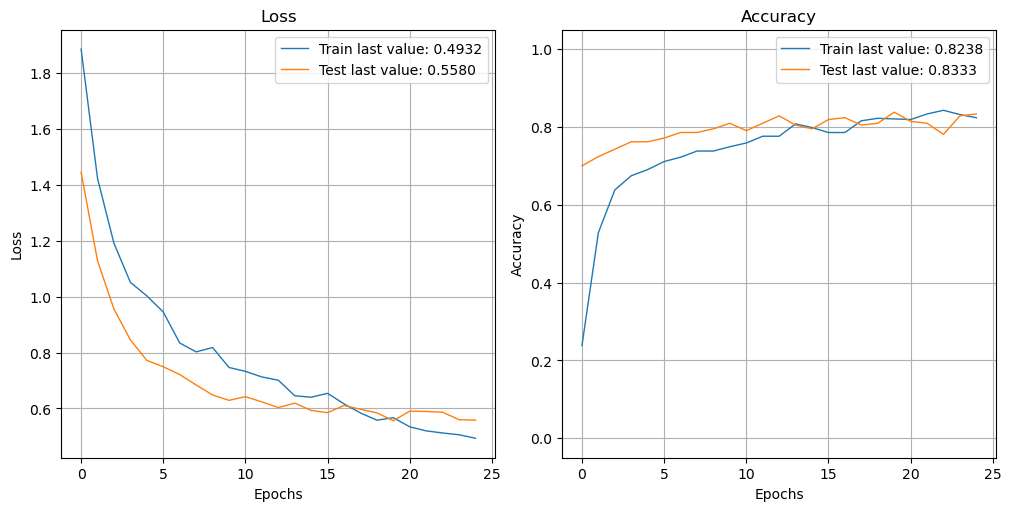

In [71]:
show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

Les scores sont très bons et contrairement à l'approche sans data augmentation, le modèle arrive à généraliser.

In [72]:
predicted_labels = []
true_labels = []
for images, labels in dataset_val:
    predicted_labels_batch = model4.predict(images)
    predicted_labels += list(np.argmax(predicted_labels_batch, axis=1))
    true_labels += list(labels.numpy())
print(true_labels)
print()
print(predicted_labels)

1/1 [==============================] - 5s 5s/step
[2, 3, 3, 2, 1, 4, 4, 4, 1, 1, 5, 2, 5, 2, 3, 3, 4, 4, 4, 6, 3, 1, 4, 1, 2, 6, 0, 4, 5, 0, 0, 6, 0, 1, 1, 2, 6, 0, 3, 0, 0, 4, 5, 4, 2, 0, 6, 2, 2, 1, 2, 6, 1, 6, 1, 5, 3, 2, 4, 1, 2, 1, 3, 4, 0, 3, 6, 0, 4, 5, 0, 3, 3, 0, 3, 6, 0, 6, 3, 6, 3, 5, 2, 3, 3, 6, 4, 1, 4, 6, 3, 0, 1, 0, 5, 6, 5, 5, 1, 4, 5, 5, 6, 3, 3, 2, 1, 4, 6, 4, 3, 4, 1, 0, 0, 4, 1, 4, 5, 1, 2, 0, 5, 2, 1, 6, 3, 5, 0, 6, 6, 0, 5, 5, 6, 3, 5, 0, 3, 5, 3, 1, 6, 3, 5, 0, 5, 3, 5, 6, 0, 3, 2, 5, 1, 0, 6, 5, 4, 3, 0, 5, 5, 5, 1, 4, 6, 6, 6, 3, 6, 4, 5, 0, 0, 2, 2, 2, 0, 2, 2, 4, 2, 5, 5, 5, 5, 2, 3, 4, 5, 1, 6, 3, 3, 6, 3, 5, 4, 5, 2, 5, 4, 3, 2, 4, 1, 4, 1, 5]

[2, 3, 0, 2, 2, 4, 5, 4, 1, 1, 2, 2, 5, 2, 3, 3, 4, 4, 4, 6, 5, 0, 4, 4, 2, 6, 0, 4, 5, 4, 0, 6, 4, 1, 1, 1, 6, 0, 0, 4, 3, 4, 5, 2, 2, 0, 6, 2, 2, 1, 2, 6, 1, 6, 1, 5, 3, 2, 4, 1, 2, 1, 4, 4, 0, 3, 6, 0, 4, 2, 4, 2, 0, 0, 3, 6, 0, 6, 2, 6, 3, 5, 2, 3, 2, 6, 4, 1, 4, 6, 3, 0, 0, 0, 5, 6, 5, 5, 1, 4, 5, 5, 6, 3, 3, 2,

In [73]:
conf_mat = metrics.confusion_matrix(true_labels, predicted_labels)
print(conf_mat)
print(metrics.classification_report(true_labels, predicted_labels))

[[21  0  0  1  5  1  0]
 [ 2 20  2  0  2  0  0]
 [ 0  2 23  0  0  1  0]
 [ 3  1  3 22  1  3  1]
 [ 0  0  1  0 28  1  0]
 [ 0  0  4  0  0 33  0]
 [ 0  0  1  0  0  0 28]]
              precision    recall  f1-score   support

           0       0.81      0.75      0.78        28
           1       0.87      0.77      0.82        26
           2       0.68      0.88      0.77        26
           3       0.96      0.65      0.77        34
           4       0.78      0.93      0.85        30
           5       0.85      0.89      0.87        37
           6       0.97      0.97      0.97        29

    accuracy                           0.83       210
   macro avg       0.84      0.83      0.83       210
weighted avg       0.85      0.83      0.83       210



<Axes: >

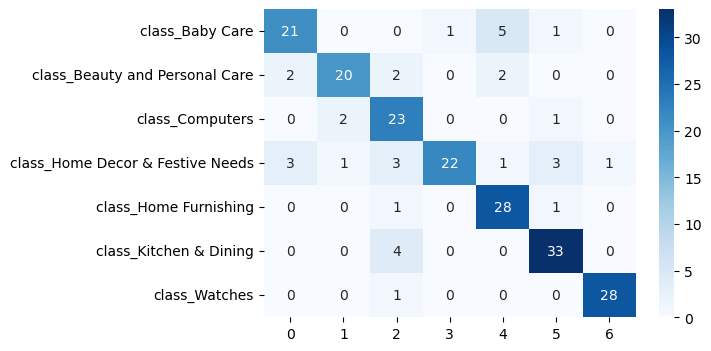

In [74]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in class_names],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

La matrice de confusion confirme les bons scores. Toutefois, la classe Kitchen & dining est encore trop souvent prédite avec cette approche.

**Prédictions sur le data test**

In [75]:
predictions4 = []
labels_test = []
for images, labels in dataset_test:
    predicted_labels_batch = model4.predict(images)
    predictions4 += list(np.argmax(predicted_labels_batch, axis=1))
    labels_test += list(labels.numpy())
print(labels_test)
print()
print(predictions4)

1/1 [==============================] - 6s 6s/step
[4, 4, 0, 4, 0, 3, 4, 1, 5, 0, 2, 2, 6, 5, 3, 0, 4, 3, 0, 2, 6, 0, 1, 5, 2, 1, 3, 0, 1, 4, 4, 5, 6, 5, 1, 1, 0, 1, 2, 2, 6, 6, 1, 2, 6, 2, 3, 2, 4, 4, 5, 3, 6, 1, 1, 4, 6, 0, 3, 1, 1, 3, 0, 5, 6, 4, 5, 3, 4, 6, 6, 6, 3, 5, 2, 1, 5, 5, 5, 1, 2, 4, 6, 1, 4, 6, 2, 4, 3, 3, 0, 0, 3, 4, 6, 2, 0, 0, 0, 1, 6, 4, 2, 5, 0, 4, 5, 2, 5, 3, 0, 6, 6, 3, 2, 3, 2, 6, 3, 1, 0, 5, 2, 3, 1, 6, 4, 3, 4, 2, 6, 5, 5, 3, 4, 1, 4, 0, 4, 6, 2, 1, 3, 1, 4, 2, 0, 5, 5, 0, 4, 2, 4, 5, 2, 0, 2, 4, 6, 5, 3, 1, 3, 0, 0, 1, 5, 0, 5, 2, 3, 3, 6, 3, 1, 1, 0, 2, 0, 2, 5, 1, 2, 5, 3, 1, 5, 2, 3, 0, 4, 6, 6, 0, 5, 2, 1, 0, 6, 3, 5, 6, 4, 6, 1, 6, 3, 1, 5, 4]

[4, 4, 0, 4, 4, 3, 4, 1, 5, 0, 2, 2, 6, 5, 3, 0, 4, 5, 2, 2, 6, 0, 1, 5, 2, 1, 3, 0, 1, 4, 4, 5, 6, 5, 1, 1, 4, 1, 2, 2, 6, 6, 1, 2, 6, 1, 3, 2, 2, 4, 5, 1, 6, 2, 1, 4, 6, 0, 3, 6, 2, 3, 0, 1, 5, 4, 5, 3, 4, 6, 6, 6, 2, 5, 2, 2, 5, 5, 0, 4, 2, 4, 6, 1, 4, 6, 3, 4, 3, 3, 0, 0, 3, 4, 6, 2, 0, 0, 0, 1, 6, 4, 2, 1, 0, 4,

In [76]:
score4_r2 = model4.evaluate(dataset_test)[1]
print("r2 : ",score4_r2)

7/7 [==============================] - 64s 9s/step - loss: 0.6228 - accuracy: 0.8143
r2 :  0.8142856955528259


In [77]:
score4_ari = metrics.adjusted_rand_score(labels_test, predictions4)
print("ARI : ", score4_ari)

ARI :  0.6195856873822976
